Model orthogonalization with LDM variants. This is an interactive jupyter notebook, that contains the following model scenarios:

* 4 classes, 2 models of each class
* 1 good model 7 bad models
* 4 good models 4 bad models
* 7 good models 1 bad model
* 1 model perfect 7 models bad
* **8 perfect models with a various scales random corruption**
* **1 model perfect 8 other models**
* **1 good model 1 bad model**
* **2 good models 10 bad models**

These scenarios are examined using PCA. One needs to make some choices when analyzing the scenarios, which in turn yields the following PCA variants:

* Raw model output  -  not standardized
* Raw model output  -  standardized
* Residuals - not standardized
* Residuals - standardized

Example: Let's say you are interested in the scenario with **1 model perfect 7 models bad** and you want to analyze **standardized residuals**, then you need to run the code chunks under the **following headings**:

1. Utilities
2. Scenario - 1 model perfect 7 models bad
3. Residuals - standardized

This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants
        ├── 4 classes, 2 models of each class
        ├── 1 good model 7 bad models
        ├── 4 good models 4 bad models
        ├── 7 good models 1 bad model
        ├── 1 model perfect 7 models bad
        ├── 8 perfect models with a various scales random corruption
        ├── 1 model perfect 8 other models
        ├── 1 good model 1 bad model
        ├── 2 good models 10 bad models
    └── PCA - Analysis
        ├── Raw model output  -  not standardized
        ├── Raw model output  -  standardized
        ├── Residuals - not standardized
        ├── Residuals - standardized
        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#def LDM_extended(params, x):
#    #x = (n,z)
#    #params= parameters (volume, surface, curv, sym, ssym, sym_2)
#    
#    n=x[0]
#    z=x[1]
#    A = n + z
#    I = (n-z)/(n+z)
#    #I = 0
#
#    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
#                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4)

def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 




def Truth(x):
    return LDM(LDM_truth_params,x)

#We should create the data (paris of [N,Z])
def data_loader():
    #input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ = pd.read_csv("NZ_even_even.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return

### Global variables####

# SkO values selected for the truth
#truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5]
truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 values selected for the truth
SLY_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1 params
NL1_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]
corruption_noise_Mass=1/3

c1_params = [SLY_params, NL1_params]
c2_params = [[-15.972, 18.4, 9, 32.01, -54, 0, 0.57], [-16.425, 18.8, 9, 43.48, -110, 0, 0.57]]
c3_params = [[-15.972, 18.4, 9, 32.01, 0, 0, 0.57], [-16.425, 18.8, 9, 43.48, 0, 0, 0.57]]
c4_params = [[-15.972, 18.4, 9, 0, 0, 0, 0.57], [-16.425, 18.8, 9, 0, 0, 0, 0.57]]

##########################

## Version 2.0 - LDM variants

### Scenario - 4 classes, 2 models of each class

In [172]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
scenario = "original"

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
params = c2_params
for i in range(n_class_2):
    models_output["c2_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])
    
n_class_3 = 2
params = c3_params
for i in range(n_class_3):
    models_output["c3_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 2
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

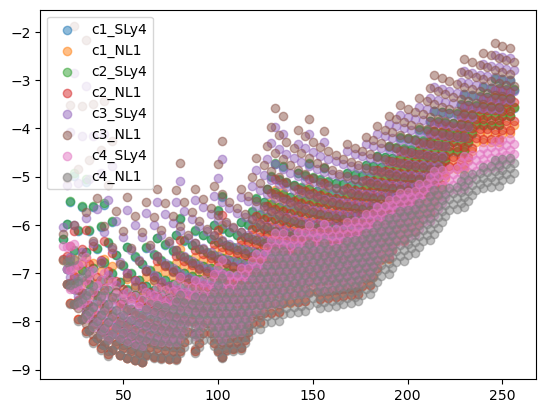

In [56]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

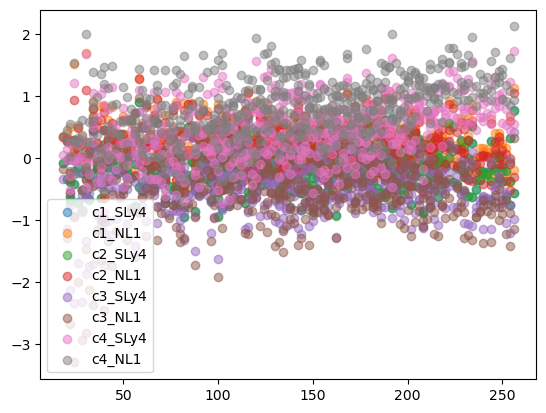

In [57]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y =masses_truth.values -  models_output_df[key].values, label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [174]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

             mean       std  res_mean   res_std      rmse
c1_SLy4 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_NL1  -6.558030  1.332515  0.267623  0.335448  0.429124
c2_SLy4 -6.139804  1.336492 -0.150603  0.323793  0.357104
c2_NL1  -6.504928  1.364964  0.214521  0.328425  0.392278
c3_SLy4 -5.832142  1.465550 -0.458265  0.422822  0.623527
c3_NL1  -5.878209  1.632567 -0.412198  0.569078  0.702679
c4_SLy4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_NL1  -7.107644  1.023128  0.817237  0.475797  0.945653
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_NL1 & -6.56 & 1.33 & 0.27 & 0.34 & 0.43 \\
c2_SLy4 & -6.14 & 1.34 & -0.15 & 0.32 & 0.36 \\
c2_NL1 & -6.50 & 1.36 & 0.21 & 0.33 & 0.39 \\
c3_SLy4 & -5.83 & 1.47 & -0.46 & 0.42 & 0.62 \\
c3_NL1 & -5.88 & 1.63 & -0.41 & 0.57 & 0.70 \\
c4_SLy4 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_NL1 & -7.11 & 1.02 & 0.82 & 0.48 & 0.95 \\
\end{tabular}



### Scenario - 1 good model 7 bad models

In [182]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g7b"
# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 7
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

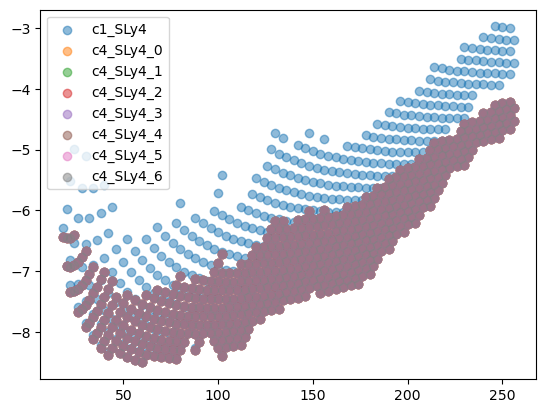

In [69]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [183]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

               mean       std  res_mean   res_std      rmse
c1_SLy4   -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_1 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_2 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_3 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_5 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_6 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_1 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_2 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_3 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_4 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_5 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_6 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\


### Scenario - 4 good models 4 bad models

In [191]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "4g4b"
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 4
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 4
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

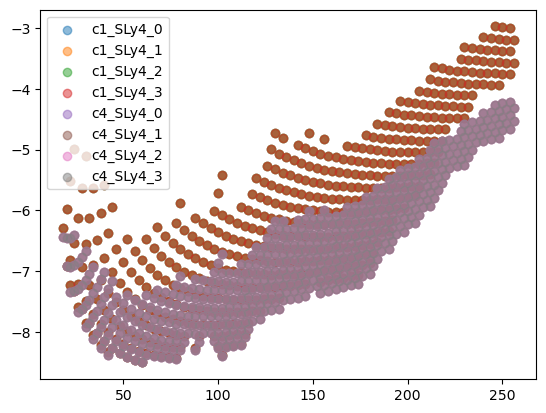

In [79]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [192]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4_0 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_1 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_2 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_3 -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_1 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_2 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_3 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_1 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_2 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_3 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_1 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_2 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_3 & -6.74 & 1.03 & 0.45 & 0.47 & 0.6

### Scenario - 7 good models 1 bad model

In [200]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "7g1b"

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 7
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

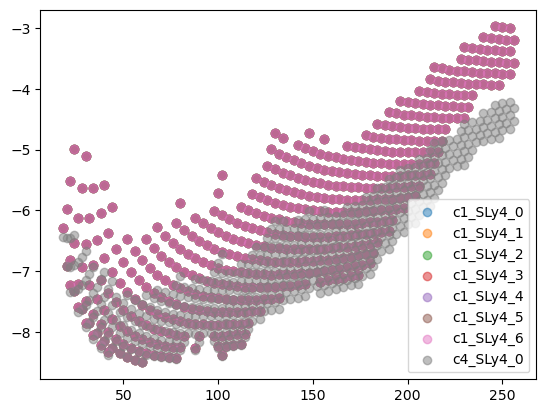

In [89]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [201]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4_0 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_1 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_2 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_3 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_4 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_5 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_6 -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_1 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_2 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_3 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_4 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_5 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_6 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 

### Scenario - 1 model perfect 7 models bad

In [209]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1p7b"
corruption_noise_Mass=1/3

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = masses_truth + np.random.randn(masses_truth.shape[0]) * 0.001

n_class_4 = 7
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

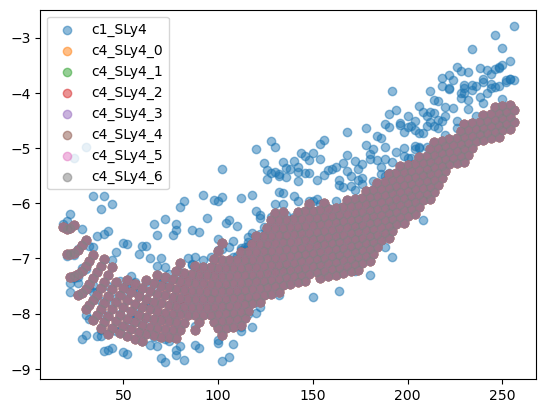

In [121]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [210]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4   -6.290487  1.359034  0.000080  0.000978  0.000982
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_1 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_2 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_3 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_5 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_6 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4 & -6.29 & 1.36 & 0.00 & 0.00 & 0.00 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_1 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_2 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_3 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_4 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_5 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4_SLy4_6 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
\

### Scenario - 8 perfect models with a various scales random corruption

In [225]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "8p0b"
corruption_noise_Mass=1/3

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
noise_scale = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128]
n_class_1 = 8
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + str(i)] = masses_truth + np.random.randn(masses_truth.shape[0]) * noise_scale[i]
    
models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

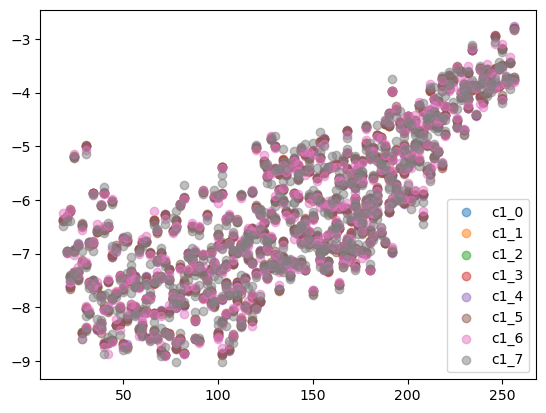

In [157]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [226]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 3).to_latex())

          mean       std  res_mean   res_std      rmse
c1_0 -6.290487  1.359034  0.000080  0.000978  0.000982
c1_1 -6.290429  1.359250  0.000022  0.002042  0.002042
c1_2 -6.290275  1.359050 -0.000132  0.004033  0.004035
c1_3 -6.290769  1.359168  0.000362  0.008094  0.008102
c1_4 -6.291850  1.360144  0.001443  0.016639  0.016702
c1_5 -6.291154  1.361478  0.000747  0.031225  0.031234
c1_6 -6.292916  1.361066  0.002509  0.064274  0.064323
c1_7 -6.290591  1.369350  0.000184  0.124002  0.124002
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_0 & -6.290 & 1.359 & 0.000 & 0.001 & 0.001 \\
c1_1 & -6.290 & 1.359 & 0.000 & 0.002 & 0.002 \\
c1_2 & -6.290 & 1.359 & -0.000 & 0.004 & 0.004 \\
c1_3 & -6.291 & 1.359 & 0.000 & 0.008 & 0.008 \\
c1_4 & -6.292 & 1.360 & 0.001 & 0.017 & 0.017 \\
c1_5 & -6.291 & 1.361 & 0.001 & 0.031 & 0.031 \\
c1_6 & -6.293 & 1.361 & 0.003 & 0.064 & 0.064 \\
c1_7 & -6.291 & 1.369 & 0.000 & 0.124 & 0.124 \\
\end{tabular}



### Scenario - 1 model perfect 8 other models

In [300]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
scenario = "1p8o"

# Fix random seed
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}

models_output["perfect"] = masses_truth + np.random.randn(masses_truth.shape[0]) * 0.001

params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

# Model class 2: truth + quadratic distortion + noise
n_class_2 = 2
params = c2_params
for i in range(n_class_2):
    models_output["c2_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])
    
n_class_3 = 2
params = c3_params
for i in range(n_class_3):
    models_output["c3_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 2
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[i]] = LDM_extended(params[i],[input_NZ["Z"], input_NZ["N"]])

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

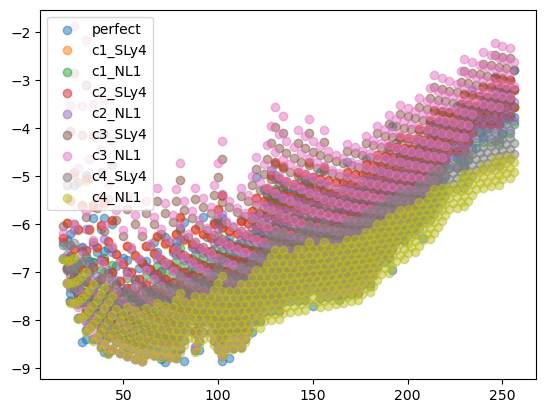

In [301]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

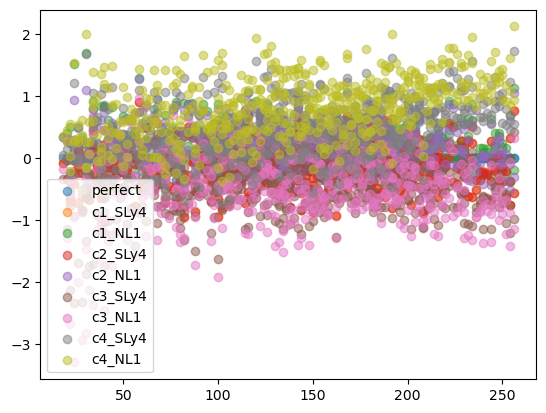

In [302]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y =masses_truth.values -  models_output_df[key].values, label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [304]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

             mean       std  res_mean   res_std      rmse
perfect -6.290487  1.359034  0.000080  0.000978  0.000982
c1_SLy4 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_NL1  -6.558030  1.332515  0.267623  0.335448  0.429124
c2_SLy4 -6.139804  1.336492 -0.150603  0.323793  0.357104
c2_NL1  -6.504928  1.364964  0.214521  0.328425  0.392278
c3_SLy4 -5.832142  1.465550 -0.458265  0.422822  0.623527
c3_NL1  -5.878209  1.632567 -0.412198  0.569078  0.702679
c4_SLy4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_NL1  -7.107644  1.023128  0.817237  0.475797  0.945653
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
perfect & -6.29 & 1.36 & 0.00 & 0.00 & 0.00 \\
c1_SLy4 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_NL1 & -6.56 & 1.33 & 0.27 & 0.34 & 0.43 \\
c2_SLy4 & -6.14 & 1.34 & -0.15 & 0.32 & 0.36 \\
c2_NL1 & -6.50 & 1.36 & 0.21 & 0.33 & 0.39 \\
c3_SLy4 & -5.83 & 1.47 & -0.46 & 0.42 & 0.62 \\
c3_NL1 & -5.88 & 1.63 & -0.41 & 0.57 & 0.70 \\
c4_SLy4 & -6.74 & 1.0

### Scenario -  1 good model 1 bad model

In [312]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "1g1b"
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 1
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])

n_class_4 = 1
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

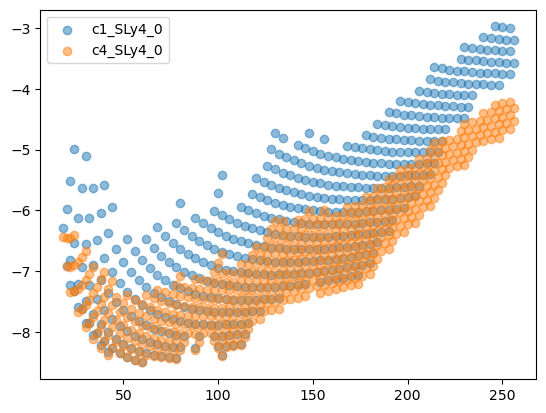

In [313]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [314]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4_0 -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
\end{tabular}



### Scenario - 2 good models 10 bad models

In [321]:
#params= parameters (volume, surface, curv, sym, ssym, sym_2)
# SkO values selected for the truth
scenario = "2g10b"
np.random.seed(23)

# Load NZ
input_NZ =  data_loader()

# truth is SLY 4 with a small noise
masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) + np.random.randn(len(input_NZ)) * corruption_noise_Mass

# Model class 1: truth + noise
n_class_1 = 2
models_output = {}
params = c1_params
models = ["SLy4", "NL1"]
for i in range(n_class_1):
    models_output["c1_" + models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]]) 

n_class_4 = 10
params = c4_params
for i in range(n_class_4):
    models_output["c4_" +  models[0] + "_" + str(i)] = LDM_extended(params[0],[input_NZ["Z"], input_NZ["N"]])
    

models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]

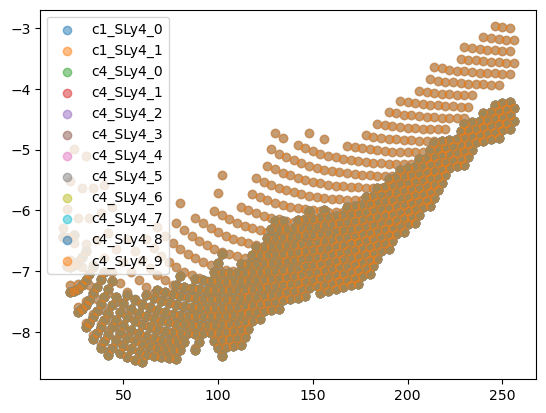

In [322]:
for key in models_output.keys():
    plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
plt.legend()
plt.savefig("Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [323]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 

model_summary = {}
model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
model_summary["res_mean"] = residuals.mean(axis = 0)
model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse"] = np.sqrt(np.mean(residuals ** 2, axis = 0))

model_summary_df = pd.DataFrame(model_summary, index =models_output.keys())
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())

               mean       std  res_mean   res_std      rmse
c1_SLy4_0 -6.144931  1.333014 -0.145476  0.323206  0.354437
c1_SLy4_1 -6.144931  1.333014 -0.145476  0.323206  0.354437
c4_SLy4_0 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_1 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_2 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_3 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_4 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_5 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_6 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_7 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_8 -6.737253  1.034223  0.446846  0.469164  0.647909
c4_SLy4_9 -6.737253  1.034223  0.446846  0.469164  0.647909
\begin{tabular}{lrrrrr}
 & mean & std & res_mean & res_std & rmse \\
c1_SLy4_0 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c1_SLy4_1 & -6.14 & 1.33 & -0.15 & 0.32 & 0.35 \\
c4_SLy4_0 & -6.74 & 1.03 & 0.45 & 0.47 & 0.65 \\
c4

## PCA - Analysis

### Raw model output  -  not standardized

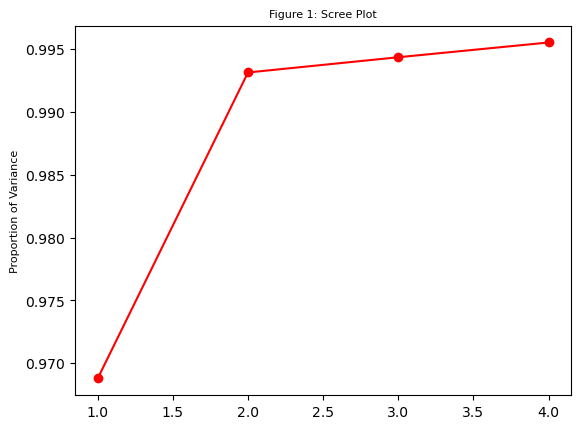

In [23]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(models_output_df[models_output.keys()])

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

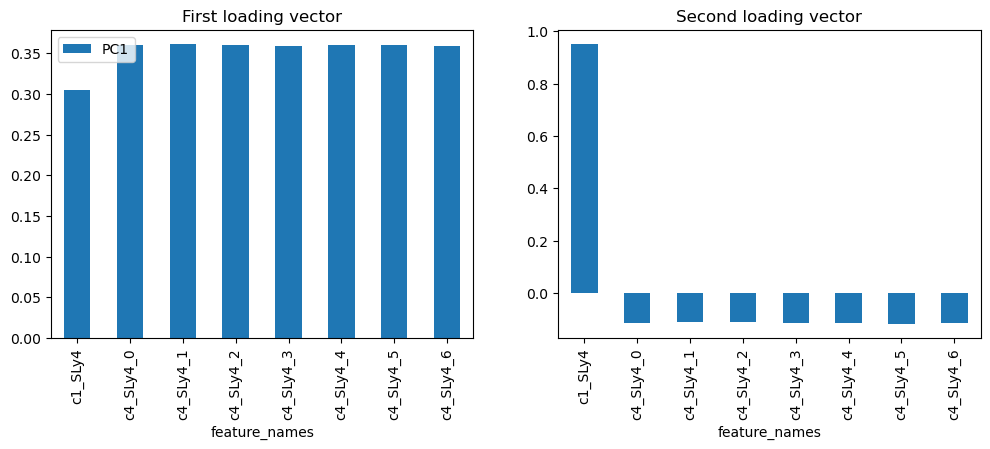

                    PC1       PC2       PC3       PC4
feature_names                                        
c1_SLy4        0.304615  0.952458  0.001646  0.003031
c4_SLy4_0      0.359904 -0.114211 -0.450550 -0.025725
c4_SLy4_1      0.360969 -0.112959 -0.333089 -0.565300
c4_SLy4_2      0.360086 -0.111761  0.387221 -0.280461
c4_SLy4_3      0.359327 -0.115066 -0.374499  0.701553
c4_SLy4_4      0.360033 -0.116166  0.358065  0.019871
c4_SLy4_5      0.360268 -0.118604  0.508130  0.295528
c4_SLy4_6      0.359423 -0.117163 -0.097253 -0.145593


In [24]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

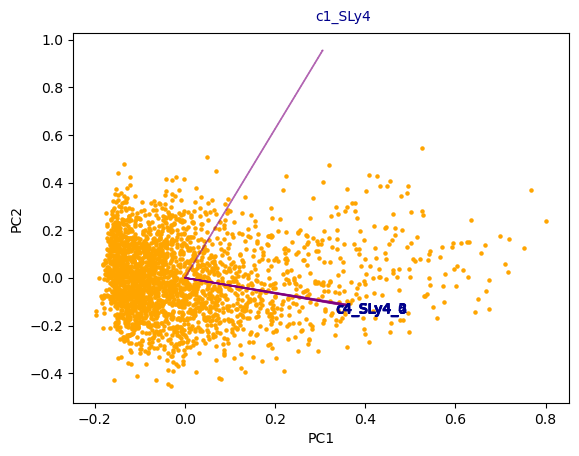

In [25]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))
plt.savefig("Biplot_Toy_raw.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Raw model output -  standardized

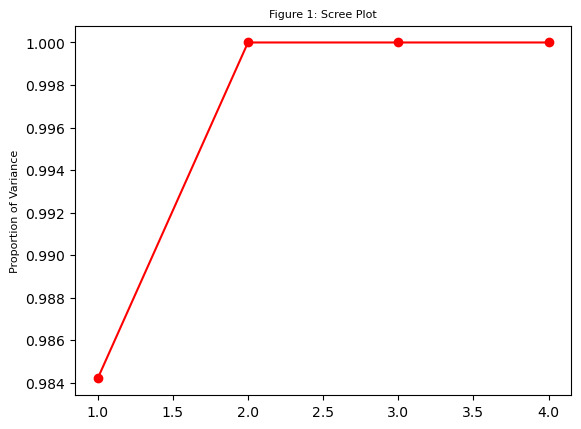

In [14]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(models_output_df[models_output.keys()])
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

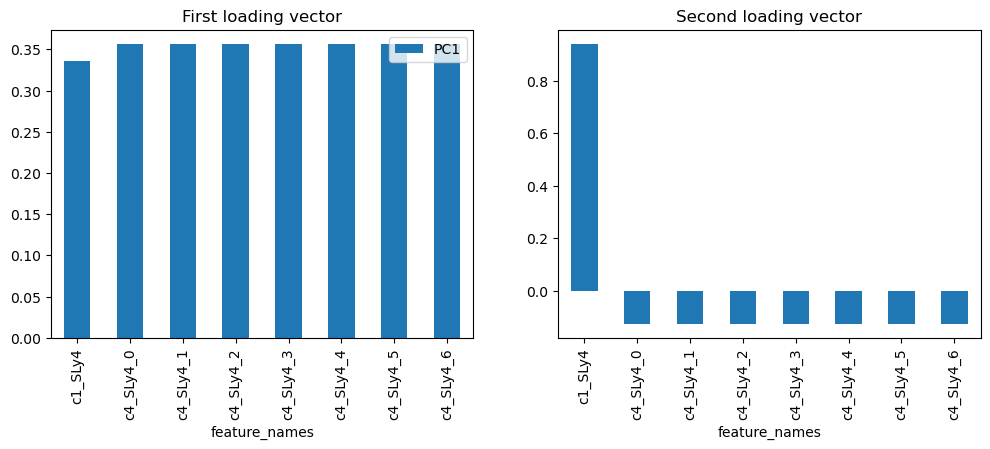

                    PC1       PC2       PC3           PC4
feature_names                                            
c1_SLy4        0.335808  0.941931 -0.000000  0.000000e+00
c4_SLy4_0      0.356016 -0.126923 -0.925820 -1.941078e-16
c4_SLy4_1      0.356016 -0.126923  0.154303  9.128709e-01
c4_SLy4_2      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_3      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_4      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_5      0.356016 -0.126923  0.154303 -1.825742e-01
c4_SLy4_6      0.356016 -0.126923  0.154303 -1.825742e-01


In [15]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

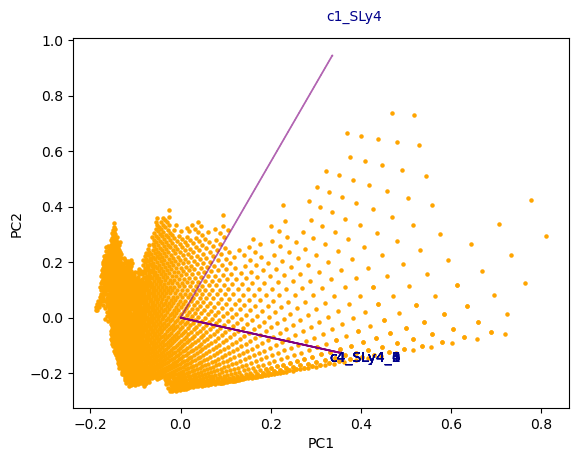

In [16]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_Toy_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Residuals - not standardized

In [324]:
residuals = masses_truth.values[:,None] - models_output_df[models_output.keys()].values 
np.corrcoef(residuals.T)

array([[1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ,

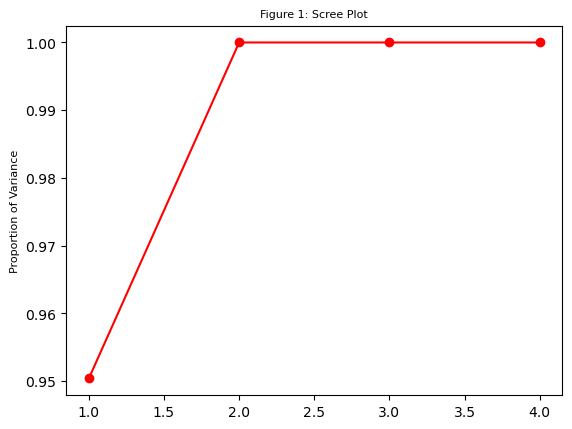

In [325]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(residuals)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

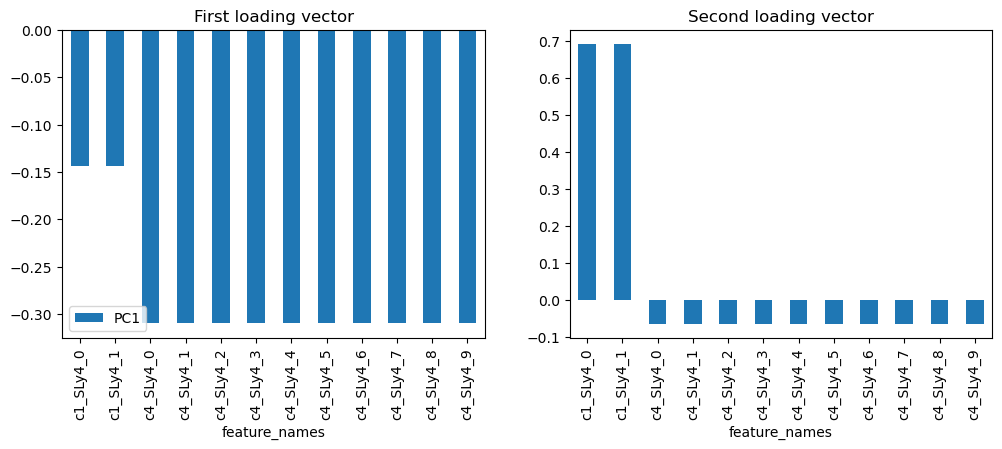

                    PC1       PC2           PC3           PC4
feature_names                                                
c1_SLy4_0     -0.143462  0.692401  7.071068e-01 -0.000000e+00
c1_SLy4_1     -0.143462  0.692401 -7.071068e-01 -4.780535e-17
c4_SLy4_0     -0.309651 -0.064158  1.028729e-16 -9.486833e-01
c4_SLy4_1     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_2     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_3     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_4     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_5     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_6     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_7     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_8     -0.309651 -0.064158  4.736177e-17  1.054093e-01
c4_SLy4_9     -0.309651 -0.064158  4.736177e-17  1.054093e-01


In [326]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

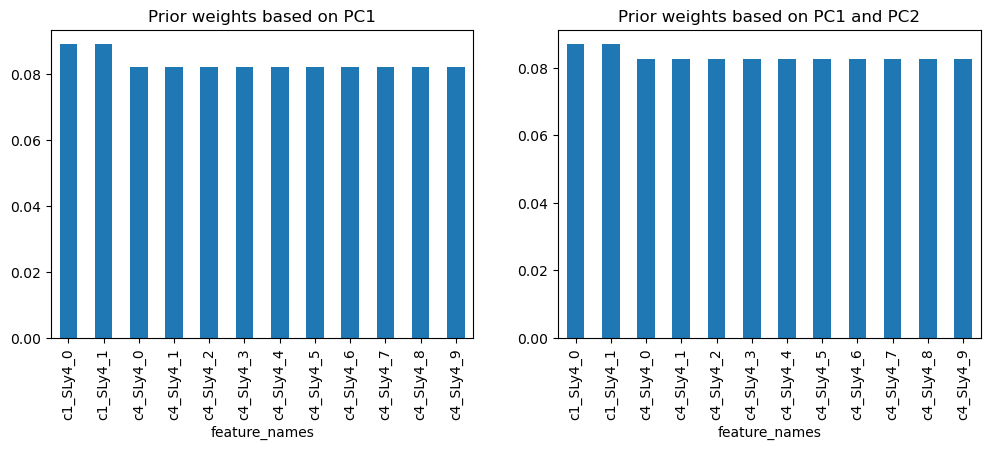

                    PC1       PC2           PC3           PC4       PW1  \
feature_names                                                             
c1_SLy4_0     -0.143462  0.692401  7.071068e-01 -0.000000e+00  0.089038   
c1_SLy4_1     -0.143462  0.692401 -7.071068e-01 -4.780535e-17  0.089038   
c4_SLy4_0     -0.309651 -0.064158  1.028729e-16 -9.486833e-01  0.082192   
c4_SLy4_1     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_2     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_3     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_4     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_5     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_6     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_7     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_8     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.082192   
c4_SLy4_9     -0.309651 -

In [327]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV1_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

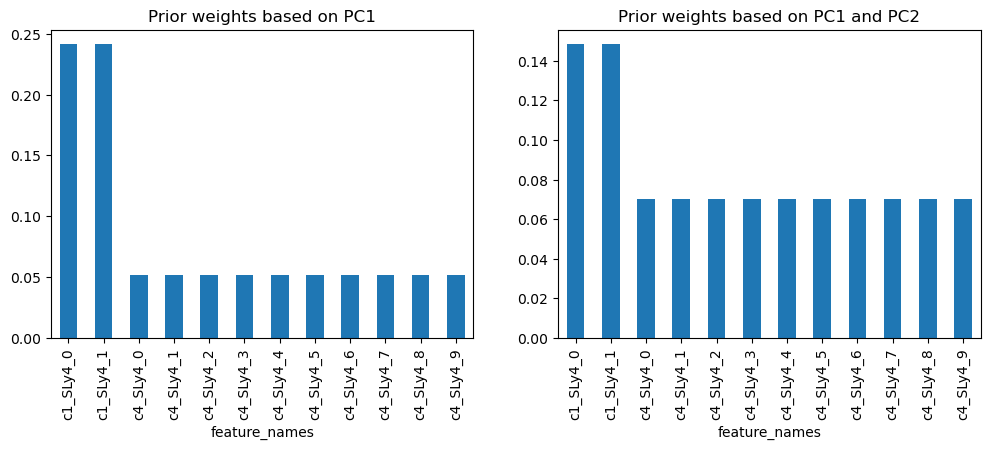

                    PC1       PC2           PC3           PC4       PW1  \
feature_names                                                             
c1_SLy4_0     -0.143462  0.692401  7.071068e-01 -0.000000e+00  0.241169   
c1_SLy4_1     -0.143462  0.692401 -7.071068e-01 -4.780535e-17  0.241169   
c4_SLy4_0     -0.309651 -0.064158  1.028729e-16 -9.486833e-01  0.051766   
c4_SLy4_1     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_2     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_3     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_4     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_5     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_6     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_7     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_8     -0.309651 -0.064158  4.736177e-17  1.054093e-01  0.051766   
c4_SLy4_9     -0.309651 -

In [328]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
plt.savefig("PC_ToyResid_weightsV2_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

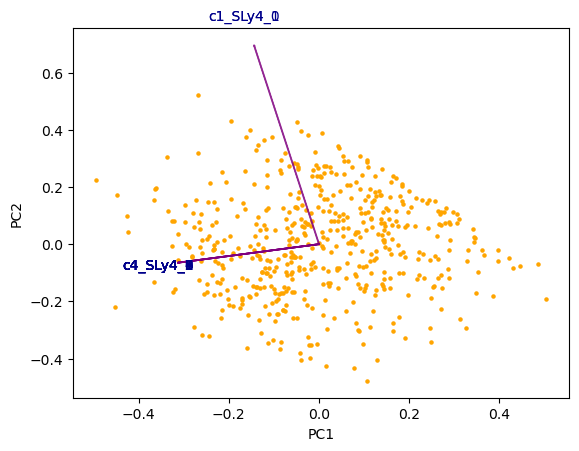

In [329]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_raw_" + scenario + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

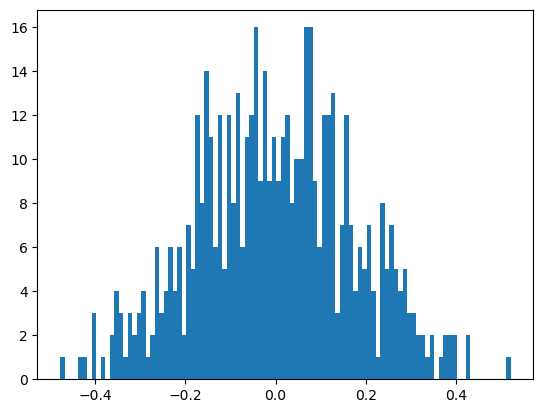

-0.47828529225015803


In [330]:
PCA_2_scaled = X_pca[:,1] / (X_pca[:,1].max() - X_pca[:,1].min())
plt.hist(PCA_2_scaled, bins = 100)
plt.show()
print(PCA_2_scaled.min())

### Residuals - standardized

In [54]:
residuals =masses_truth.values[:,None] - models_output_df[models_output.keys()].values
np.corrcoef(residuals.T)

array([[1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [1.        , 1.        , 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443, 0.63599443, 0.63599443, 0.63599443,
        0.63599443, 0.63599443],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.63599443, 0.63599443, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        ,

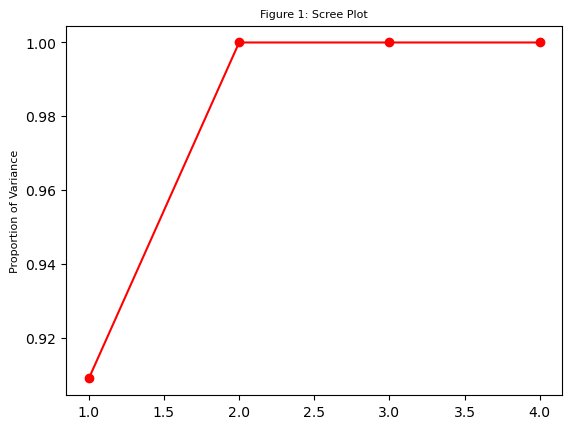

In [55]:
pca = PCA(n_components=4)
X_scaled = StandardScaler().fit_transform(residuals)
X_pca = pca.fit_transform(X_scaled)

prop_var = np.cumsum(pca.explained_variance_ratio_)
PC_numbers = np.arange(pca.n_components_) + 1
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.savefig("Scree_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()

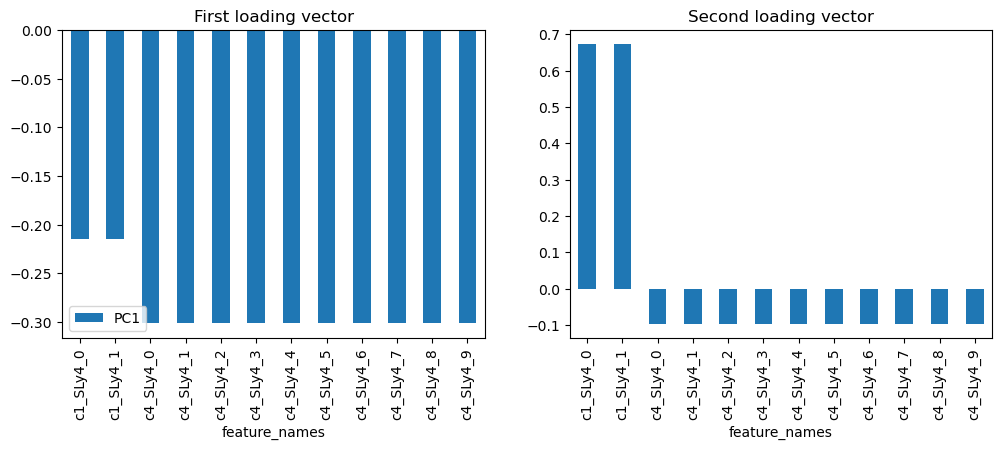

                    PC1       PC2           PC3           PC4
feature_names                                                
c1_SLy4_0     -0.215073  0.673605 -7.071068e-01 -0.000000e+00
c1_SLy4_1     -0.215073  0.673605  7.071068e-01 -2.129364e-16
c4_SLy4_0     -0.301245 -0.096184 -1.244732e-16 -9.486833e-01
c4_SLy4_1     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_2     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_3     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_4     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_5     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_6     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_7     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_8     -0.301245 -0.096184 -6.896201e-17  1.054093e-01
c4_SLy4_9     -0.301245 -0.096184 -6.896201e-17  1.054093e-01


In [56]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.iloc[:, :1].plot(kind = "bar", title = "First loading vector", ax = ax1)
loadings.iloc[:, 1].plot(kind = "bar", title = "Second loading vector", ax = ax2)
plt.savefig("PC_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

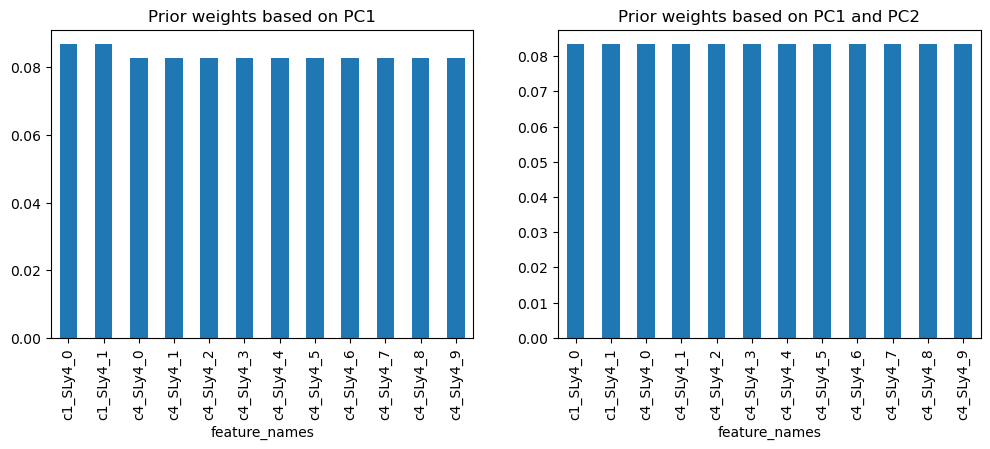

                    PC1       PC2           PC3           PC4       PW1  \
feature_names                                                             
c1_SLy4_0     -0.215073  0.673605 -7.071068e-01 -0.000000e+00  0.086704   
c1_SLy4_1     -0.215073  0.673605  7.071068e-01 -2.129364e-16  0.086704   
c4_SLy4_0     -0.301245 -0.096184 -1.244732e-16 -9.486833e-01  0.082659   
c4_SLy4_1     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_2     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_3     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_4     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_5     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_6     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_7     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_8     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.082659   
c4_SLy4_9     -0.301245 -

In [57]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = (1 - loadings["PC1"] ** 2) / np.sum((1 - loadings["PC1"] ** 2))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 - loadings["W2"]) / np.sum((1 - loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV1.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

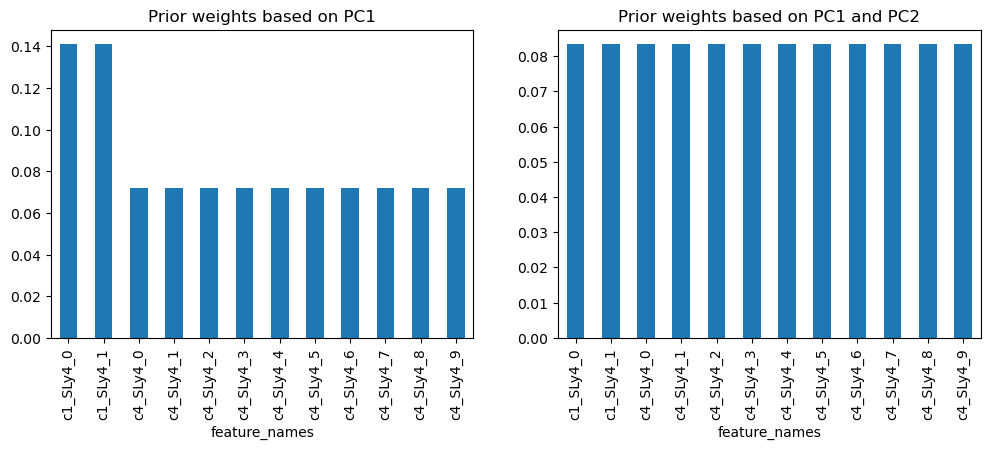

                    PC1       PC2           PC3           PC4      PW1  \
feature_names                                                            
c1_SLy4_0     -0.215073  0.673605 -7.071068e-01 -0.000000e+00  0.14090   
c1_SLy4_1     -0.215073  0.673605  7.071068e-01 -2.129364e-16  0.14090   
c4_SLy4_0     -0.301245 -0.096184 -1.244732e-16 -9.486833e-01  0.07182   
c4_SLy4_1     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_2     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_3     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_4     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_5     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_6     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_7     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_8     -0.301245 -0.096184 -6.896201e-17  1.054093e-01  0.07182   
c4_SLy4_9     -0.301245 -0.096184 -6.8

In [58]:
loadings = loading_matrix(pca.components_, pca.n_features_, models_output_df[models_output.keys()].columns)

loadings["PW1"] = ( 1 / (loadings["PC1"] ** 2)) / np.sum((1/ (loadings["PC1"] ** 2)))
loadings["W2"] =  (pca.explained_variance_ratio_[0] * loadings["PC1"] ** 2 +  pca.explained_variance_ratio_[1] * loadings["PC2"] ** 2) / np.sum(pca.explained_variance_ratio_[:2])
loadings["PW2"] = (1 / loadings["W2"]) / np.sum(( 1/ loadings["W2"]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
loadings.loc[:, "PW1"].plot(kind = "bar", title = "Prior weights based on PC1", ax = ax1)
loadings.loc[:, "PW2"].plot(kind = "bar", title = "Prior weights based on PC1 and PC2", ax = ax2)
#plt.savefig("PC_ToyResid_weightsV2.pdf", format="pdf", bbox_inches="tight")
plt.show()
print(loadings)

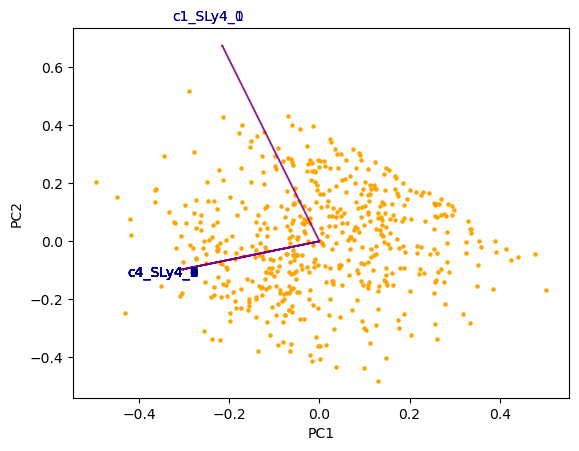

In [59]:
biplot(X_pca, np.transpose(pca.components_),list(loadings.index))

plt.savefig("Biplot_ToyResid_standardized.pdf", format="pdf", bbox_inches="tight")
plt.show()